# Blood Cell Subtype Classification 

we will  process and load the images, and build  Convolutional Neural Network using keras. The evaluation will be done using SkLearn's Classification Reports, Accuracy/Loss charts and Confusion Matrices. 


Relevant packages and libraries are imported 

In [1]:
!pip install imutils


  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=20a8876dac704d5fe629d24114409211dc00fe2ab37ea23525b7c8f708b84cc2
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils


# Object detection:

did object detection using opencv by findig edges in the images the extract contours and from contours get image boxes

In [3]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged


In [4]:
def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [5]:
def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

# Loading Data:

Load_data function that loads images and labels from the Train and Test folders and combines the datasets to return Image-Label pairs 
combining the Train/Test folders and recreate the dataset .

In [6]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,120)

In [7]:
def load_data():

    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [8]:
images, labels = load_data()

100%|██████████| 623/623 [00:05<00:00, 122.12it/s]


All data (Training and Test combined) is shuffled and split into Training (80%), Validation (10%), Test (10%) sets

In [9]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Data Exploration

- How many training, validation and testing examples do we have ? What shape are the images and labels ? 

- What is the proportion of each observed category ? Are the datasets balanced ? 

In [10]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 9716
Number of validation examples: 1215
Number of testing examples: 1215
Training images are of shape: (9716, 120, 120, 3)
Training labels are of shape: (9716,)
Validation images are of shape: (1215, 120, 120, 3)
Validation labels are of shape: (1215,)
Test images are of shape: (1215, 120, 120, 3)
Test labels are of shape: (1215,)


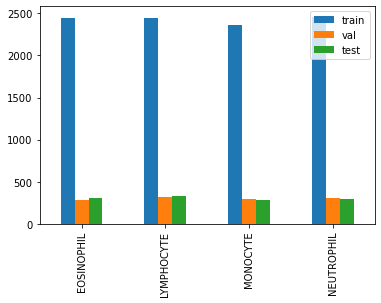

In [11]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

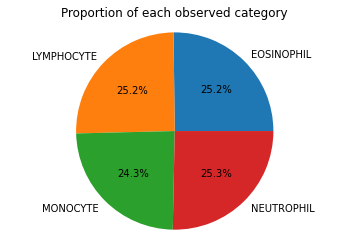

In [12]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

A quick note on preparing the data: Pixel values in RGB images are represented by integers between 0..255. Data is normalised so pixel values are between 0..1 to increase computational speed. 

In [13]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

Another sanity check: Visualise the data by displaying a single random image and 25 random images from the training set with corresponding labels. 


9716


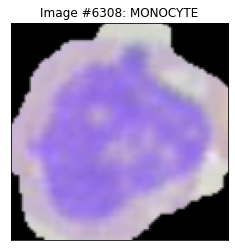

In [14]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

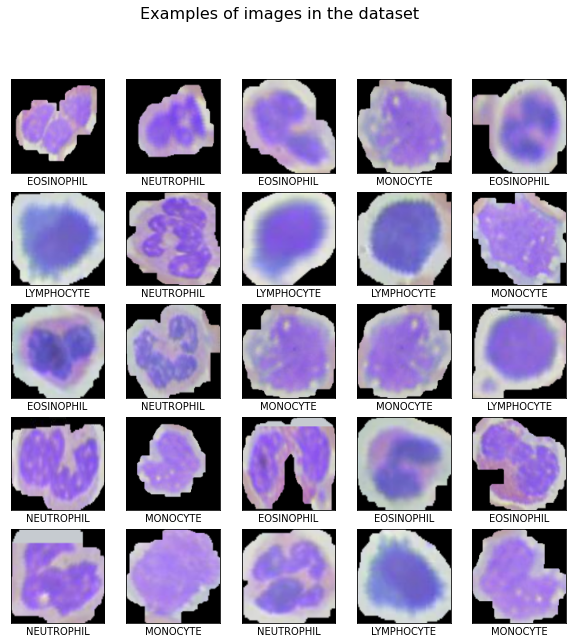

In [15]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# Custom built CNN

This model contains a sequence of five Conv blocks containing combinations of SeparableConv2D, BatchNormalization, MaxPooling and Dropout layers. The output of the final Conv block is flattened and followed by three Fully Connected (FC) layers each with its own Dropout layer. A final FC layer is added with four units and a softmax activation for multiclass classification. 

In [16]:
model1 = Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model1.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))


# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'tanh'))
model1.add(Dropout(0.7))
model1.add(Dense(units = 128 , activation = 'tanh'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 64 , activation = 'tanh'))
model1.add(Dropout(0.3))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 60, 60, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 60, 60, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0

304/304 [==============================] - 12s 39ms/step - loss: 0.0408 - accuracy: 0.9863 - val_loss: 0.0613 - val_accuracy: 0.9819
Epoch 26/30
304/304 [==============================] - 12s 39ms/step - loss: 0.0407 - accuracy: 0.9880 - val_loss: 0.0614 - val_accuracy: 0.9819
Epoch 27/30
304/304 [==============================] - 12s 39ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0608 - val_accuracy: 0.9827
Epoch 28/30
304/304 [==============================] - 12s 39ms/step - loss: 0.0455 - accuracy: 0.9842 - val_loss: 0.0607 - val_accuracy: 0.9819
Epoch 29/30
304/304 [==============================] - 12s 39ms/step - loss: 0.0451 - accuracy: 0.9865 - val_loss: 0.0608 - val_accuracy: 0.9819
Epoch 30/30
304/304 [==============================] - 12s 39ms/step - loss: 0.0424 - accuracy: 0.9844 - val_loss: 0.0609 - val_accuracy: 0.9811


# Evaluating performance

Following model training I emplemented a helper function to plot Accuracy vs Epoch and Loss vs Epoch for both the Training and Validation sets


In [17]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

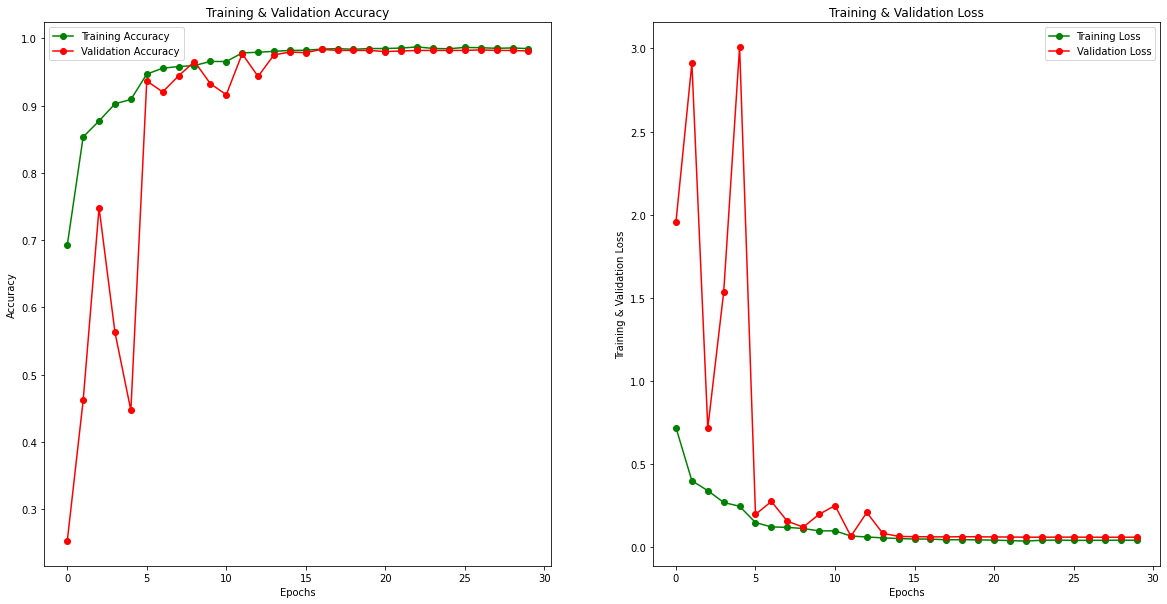

In [18]:
plot_accuracy_loss_chart(history1)

Lets evaluate the model on test data to find the loss and accuracy:


In [19]:

results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model1.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

38/38 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9860
Loss of the model  is - test  0.06715497374534607
Accuracy of the model is - test 98.60082268714905 %
38/38 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9811
Loss of the model  is - val  0.060888051986694336
Accuracy of the model is - val 98.10699820518494 %
304/304 [==============================] - 2s 7ms/step - loss: 0.0176 - accuracy: 0.9926
Loss of the model  is - train  0.017597157508134842
Accuracy of the model is - train 99.258953332901 %


Model (and weights) are saved after training. The best model and its weights can also be saved using the ModelCheckpoint callback if "EarlyStopping" is activated in the Model.fit phase. [More on this here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

I decided against using EarlyStopping, but I will try to include it in future work on this dataset. 

In [20]:
model1.save('Bloodcell_Classification_Model1_Custom_Build_10_epochs.h5')

In [21]:
from sklearn.metrics import classification_report

predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 1, 3, 2, 3, 1, 3, 2, 1, 3, 1, 2, 0, 2, 3])

In [22]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.98      0.98      0.98       309
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       329
  MONOCYTE (Class 2)       0.99      0.99      0.99       280
NEUTROPHIL (Class 3)       0.98      0.98      0.98       297

            accuracy                           0.99      1215
           macro avg       0.99      0.99      0.99      1215
        weighted avg       0.99      0.99      0.99      1215



A second helper function is created to plot confusion matrix. which will give us a better visualization of these results. 

In [23]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,302,0,3,4
1,0,329,0,0
2,0,0,277,3
3,6,0,1,290


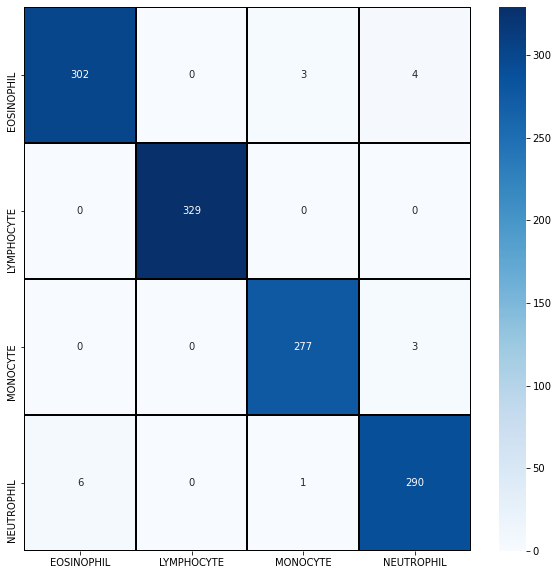

In [24]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

# References

Some code was adapted from [kbrans](https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits),[Vincee](https://www.kaggle.com/vincee/intel-image-classification-cnn-keras) and [Abhinav Sagar](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8)